In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
pickle_file = 'notMNIST_clean.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (8913, 28, 28) (8913,)
Test set (8695, 28, 28) (8695,)


In [4]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32) # Conv net
    #(-1, image_size, image_size)).astype(np.float32)  # Deep net
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (8913, 28, 28, 1) (8913, 10)
Test set (8695, 28, 28, 1) (8695, 10)


With training data
Image shape: (28, 420, 1)


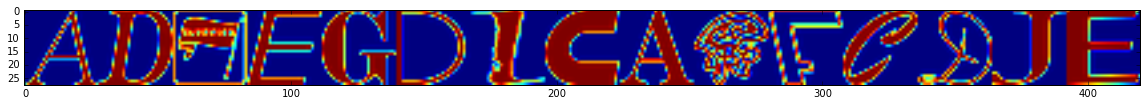

Label shape: (15, 10)
ADAEGDICABFCDJE
With testing data
Image shape: (28, 280, 1)


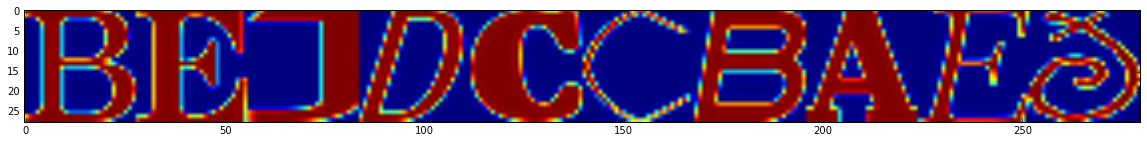

Label shape: (10, 10)
BEJDCCBAEJ
Image shape: (28, 140, 1)


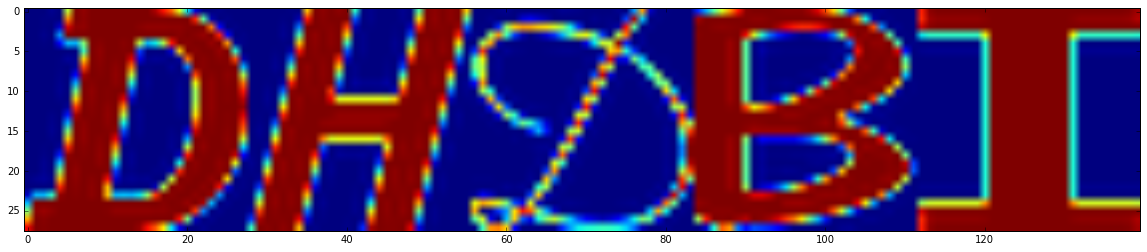

Label shape: (5, 10)
DHDBI
Image shape: (28, 140, 1)


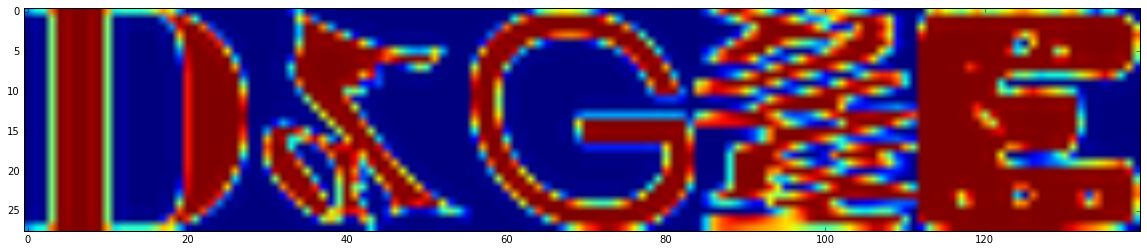

Label shape: (5, 10)
DDGIE
Image shape: (28, 140, 1)


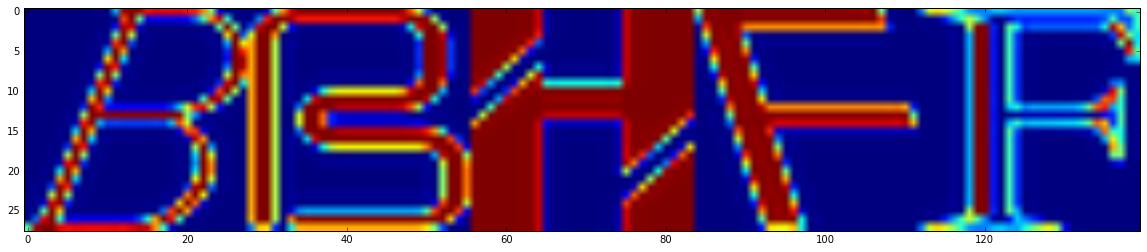

Label shape: (5, 10)
BBHFF


In [5]:
# Create a sequence of digits from the training data
#
# returns (joined image, labels)
def create_sequence(train, labels, length=5):
    result_image = None
    result_labels = []    
    for a in range(length):
        # Choose random indexes for the digits
        index = np.random.randint(0, labels.shape[0])
        
        if result_image is None:
            result_image = train[index].copy()
            #result_image = np.append(result_image, train[index], 1)
        else:
            result_image = np.append(result_image, train[index], 1)
        
        result_labels.append(labels[index])

    return result_image, np.array(result_labels)
           
def show_image(data):
    print("Image shape:", data.shape)
    plt.figure(figsize=(20, 5))
    plt.imshow(np.reshape(data, data.shape[:-1]))
    plt.show()
    
def show_label(label):
    print("Label shape:", label.shape)
    result = ''
    for a in label:
        index = np.argmax(a)
        result += chr(ord('A') + index)
    print(result)
    
print("With training data")
image, label = create_sequence(train_dataset, train_labels, length=15)
show_image(image)
show_label(label)

print("With testing data")
image, label = create_sequence(test_dataset, test_labels, length=10)
show_image(image)
show_label(label)

# Create a batch of images and labels
def generate_batch(data, labels, size, length, **kwargs):    
    images, labels = zip(*[create_sequence(data, labels, length, **kwargs) for i in range(size)])
        
    result_images = np.array(images)
    result_labels = np.array(labels)
    
    return result_images, result_labels

images, labels = generate_batch(train_dataset, train_labels, 3, 5)

for i in range(len(labels)):
    show_image(images[i])
    show_label(labels[i])

Training shape: (10000, 28, 140, 1) (10000, 5, 10)
Validation shape: (1000, 28, 140, 1) (1000, 5, 10)
Testing shape: (10000, 28, 140, 1) (10000, 5, 10)
Image shape: (28, 140, 1)


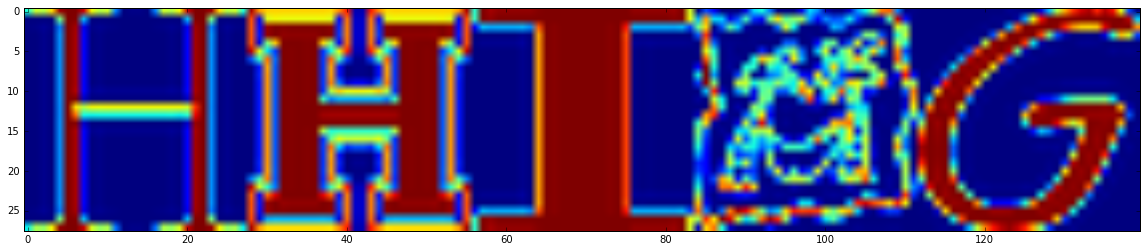

Label shape: (5, 10)
HHIGG
Image shape: (28, 140, 1)


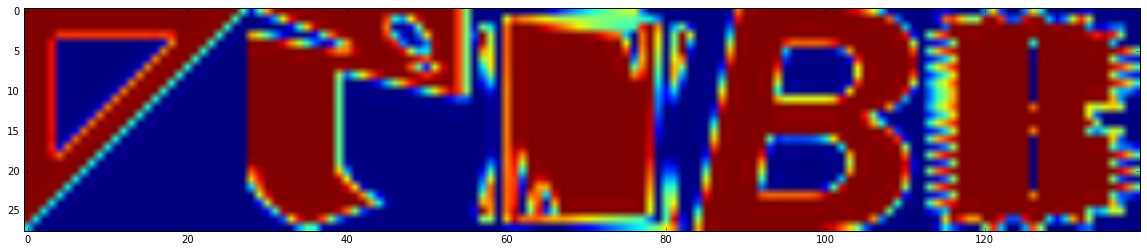

Label shape: (5, 10)
DIIBB
Image shape: (28, 140, 1)


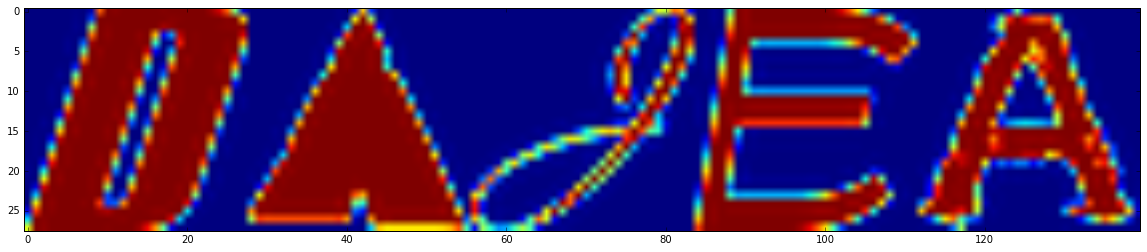

Label shape: (5, 10)
DAJEA


In [6]:
# Lets create our training, validation and testing datasets
num_digits = 5

train_dataset_imgs, train_dataset_labels = generate_batch(train_dataset, train_labels, 10000, num_digits)
valid_dataset_imgs, valid_dataset_labels = generate_batch(valid_dataset, valid_labels, 1000, num_digits)
test_dataset_imgs, test_dataset_labels = generate_batch(test_dataset, test_labels, 10000, num_digits)

print("Training shape:", train_dataset_imgs.shape, train_dataset_labels.shape)
print("Validation shape:", valid_dataset_imgs.shape, valid_dataset_labels.shape)
print("Testing shape:", test_dataset_imgs.shape, test_dataset_labels.shape)

show_image(train_dataset_imgs[110])
show_label(train_dataset_labels[110])
show_image(valid_dataset_imgs[110])
show_label(valid_dataset_labels[110])
show_image(test_dataset_imgs[110])
show_label(test_dataset_labels[110])

In [7]:

batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

img_height, img_width = test_dataset_imgs[0].shape[:2]

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")
    
  tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                      num_labels), name="tf_train_labels_%d" % i)
                     for i in range(num_digits)]
  tf_valid_dataset = tf.constant(valid_dataset_imgs, name="tf_valid_dataset")
  tf_test_dataset = tf.constant(test_dataset_imgs, name="tf_test_dataset")
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=0.1), name="layer1_weights")
  layer1_biases = tf.Variable(tf.zeros([depth]), name="layer1_biases")

  layer2_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    depth,
                                                    depth], stddev=0.1), name="layer2_weights")
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]), name="layer2_biases")

  layer3_weights = tf.Variable(tf.truncated_normal([img_height // 4 * img_width // 4 * depth,
                                                    num_hidden], stddev=0.1), name="layer3_weights")
    
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name="layer3_biases")

  layer4_weights = [tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels], stddev=0.1), name="layer4_weights")
                    for i in range(num_digits)]
  layer4_biases = [tf.Variable(tf.constant(1.0, shape=[num_labels]), name="layer4_biases")
                   for i in range(num_digits)]

   
    
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    output = [tf.matmul(hidden, layer4_weights[i]) + layer4_biases[i]
              for i in range(num_digits)]
    return output
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean([
    tf.nn.softmax_cross_entropy_with_logits(logits[i], tf_train_labels[i])
        for i in range(num_digits)])
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = [tf.nn.softmax(a) for a in logits]
  valid_prediction = [tf.nn.softmax(a) for a in model(tf_valid_dataset)]
  test_prediction = [tf.nn.softmax(a) for a in model(tf_test_dataset)]

In [ ]:
num_steps = 1001

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
#     offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
#     batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
#     batch_labels = train_labels[offset:(offset + batch_size), :]
    
#     print(batch_data.shape)
#     print(batch_labels.shape)
    
#     batch_data = train_dataset_imgs[offset:(offset + batch_size), :, :, :]
#     batch_labels = train_dataset_labels[offset:(offset + batch_size), 0, :]
#     print(batch_data.shape)
#     print(batch_labels.shape)
    
    
    batch_data, batch_labels = generate_batch(train_dataset, train_labels, batch_size, num_digits)

    
#     feed_dict = {tf_train_dataset : batch_data,
#                  tf_train_labels : batch_labels[:, 0, :]}
    
    feed_dict = {tf_train_dataset : batch_data}
    for i in range(num_digits):
        labels = batch_labels[:, i, :]
        feed_dict[tf_train_labels[i]] = labels
    
#     show_image(batch_data[0])
#     show_label(batch_labels[0])
    fetches = [optimizer, loss] + train_prediction
    
    #_, l, predictions = session.run(fetches, feed_dict=feed_dict)
    results = session.run(fetches, feed_dict=feed_dict)
    
    
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, results[1]))       
        
      print('Minibatch accuracy: %.1f%%' % np.mean([accuracy(results[2+i], batch_labels[:, i, :])
                                                    for i in range(num_digits)]))
      print('Validation accuracy: %.1f%%' % np.mean([accuracy(valid_prediction[i].eval(),
                                                              valid_dataset_labels[:, i, :])
                                                     for i in range(num_digits)]))
  print('Test accuracy: %.1f%%' % np.mean([accuracy(test_prediction[i].eval(),
                                                    test_dataset_labels[:, i, :])
                                           for i in range(num_digits)]))
  results = [layer1_weights.eval(),
             layer1_biases.eval(),
             layer2_weights.eval(),
             layer2_biases.eval()]

Initialized
Minibatch loss at step 0: 4.931939
Minibatch accuracy: 11.2%
Validation accuracy: 9.7%
Minibatch loss at step 50: 2.304597
Minibatch accuracy: 11.2%
Validation accuracy: 10.8%
Minibatch loss at step 100: 2.301500
Minibatch accuracy: 12.5%
Validation accuracy: 10.8%
Minibatch loss at step 150: 2.292699
Minibatch accuracy: 11.2%
Validation accuracy: 10.6%
Minibatch loss at step 200: 2.302051
Minibatch accuracy: 15.0%
Validation accuracy: 10.4%
Minibatch loss at step 250: 2.305265
Minibatch accuracy: 3.8%
Validation accuracy: 10.3%
Minibatch loss at step 300: 2.300914
Minibatch accuracy: 12.5%
Validation accuracy: 11.4%
Minibatch loss at step 350: 2.286900
Minibatch accuracy: 16.2%
Validation accuracy: 10.1%
Minibatch loss at step 400: 2.298635
Minibatch accuracy: 8.8%
Validation accuracy: 11.7%
Minibatch loss at step 450: 2.286154
Minibatch accuracy: 16.2%
Validation accuracy: 10.5%
Minibatch loss at step 500: 2.290151
Minibatch accuracy: 8.8%
Validation accuracy: 11.8%
Minib

In [12]:
layer1_weights, layer1_biases, layer2_weights, layer2_biases = results

In [13]:
print(layer1_weights.shape)

(5, 5, 1, 16)


(5, 5)


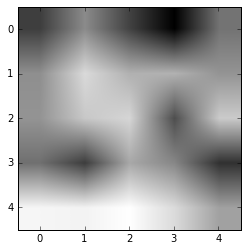

(5, 5)


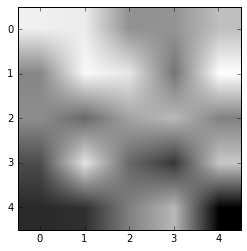

(5, 5)


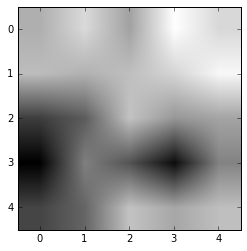

(5, 5)


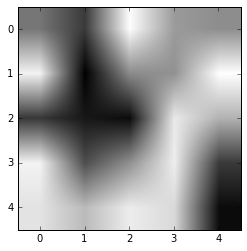

(5, 5)


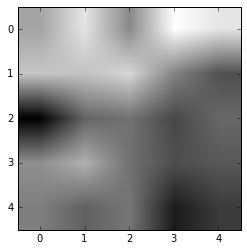

(5, 5)


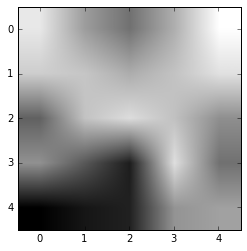

(5, 5)


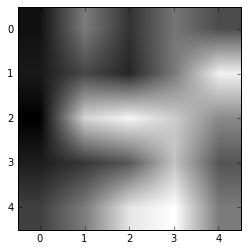

(5, 5)


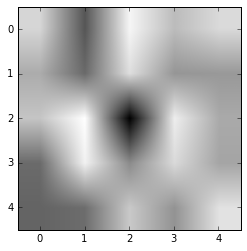

(5, 5)


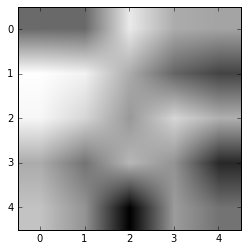

(5, 5)


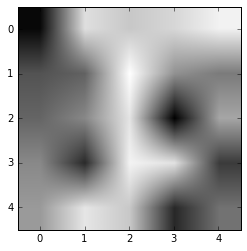

(5, 5)


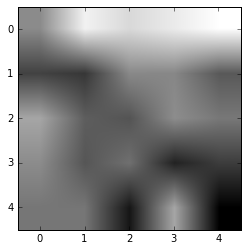

(5, 5)


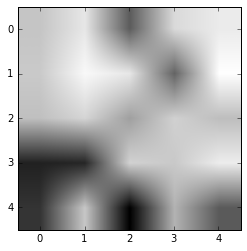

(5, 5)


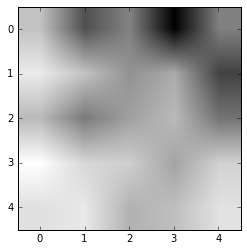

(5, 5)


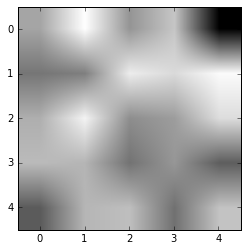

(5, 5)


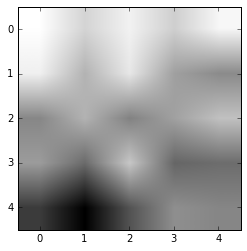

(5, 5)


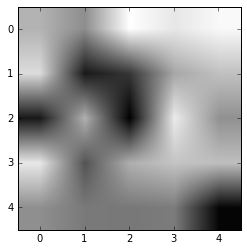

In [22]:
for a in range(layer2_weights.shape[-1]):
    pic = layer1_weights[:, :, 0, a]
    print(pic.shape)
    plt.imshow(pic, cmap='Greys_r')
    plt.show()